Dataset Shape: (400, 26)

Data Types:
 id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

Missing Values:
 id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu         

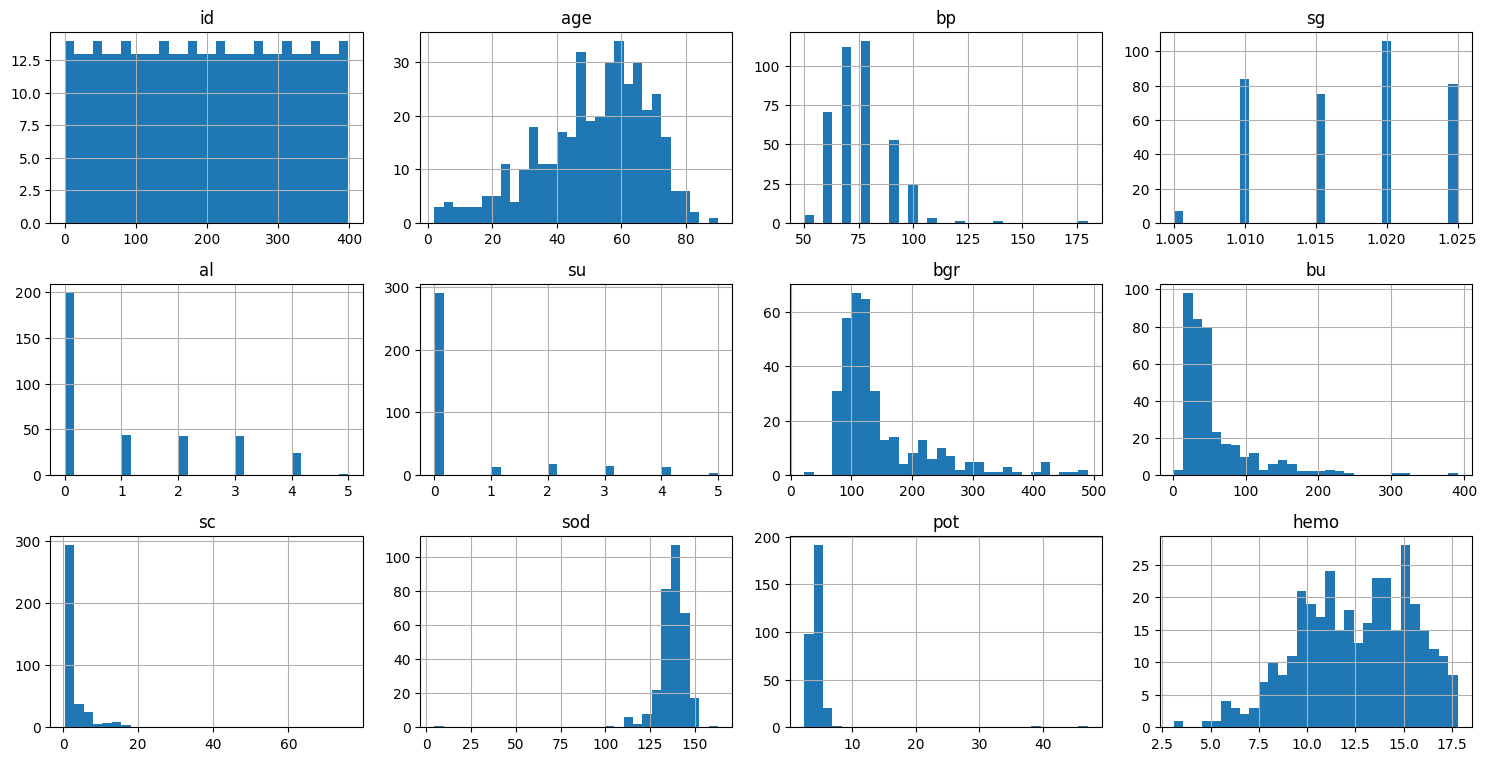

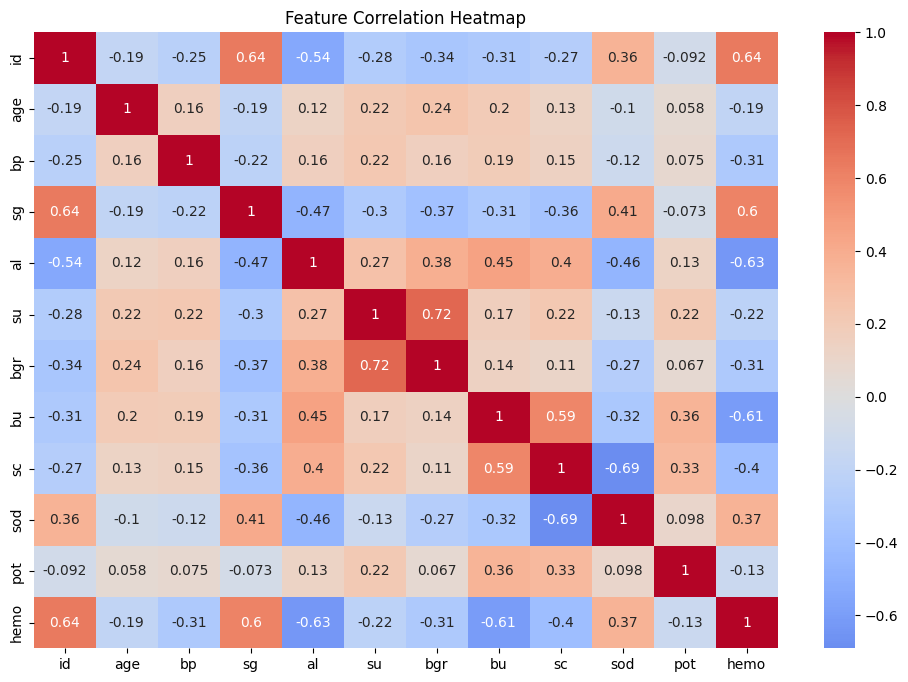

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


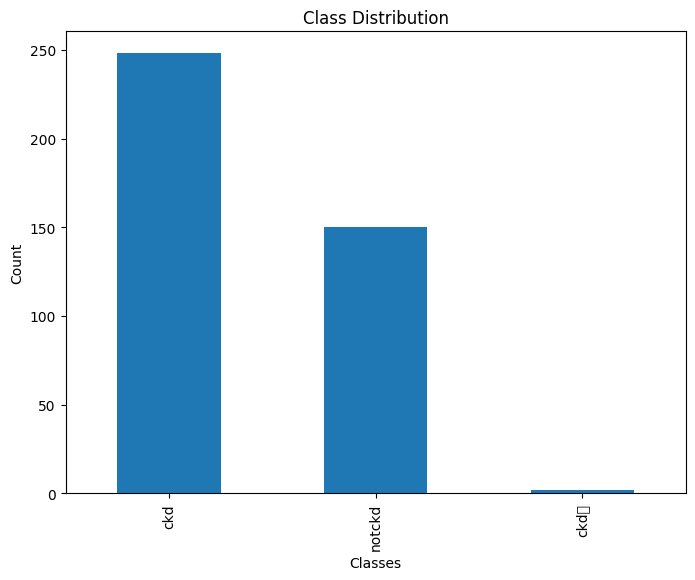

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/kidney_disease.csv')

print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print(df.describe())

plt.figure(figsize=(15, 10))
numeric_cols = df.select_dtypes(include=[np.number]).columns
for i, column in enumerate(numeric_cols):
    plt.subplot(4, 4, i+1)
    df[column].hist(bins=30)
    plt.title(column)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

plt.figure(figsize=(8, 6))
df['classification'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

In [17]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

numeric_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(include=['object']).columns

numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Impute numeric columns first
df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])

# Impute categorical columns separately
if not categorical_columns.empty:
    df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

label_encoders = {}
for column in categorical_columns:
    if column != 'classification':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le

target_encoder = LabelEncoder()
df['classification'] = target_encoder.fit_transform(df['classification'])

X = df.drop('classification', axis=1)
y = df['classification']

# Calculate the minimum number of samples in any class
min_class_count = y.value_counts().min()

# Set k_neighbors to be less than or equal to the minimum class count minus 1
# If min_class_count is 1, SMOTE cannot be applied, so handle this case.
k_neighbors = max(1, min_class_count - 1)

if k_neighbors > 0:
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X, y)
else:
    # Handle the case where SMOTE cannot be applied (e.g., all classes have only 1 sample)
    print("SMOTE cannot be applied as the minimum class has too few samples.")
    X_resampled, y_resampled = X, y # Or handle as appropriate for your use case


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb

models = {
    'logistic': LogisticRegression(max_iter=1000),
    'dt': DecisionTreeClassifier(random_state=42),
    'rf': RandomForestClassifier(n_estimators=100, random_state=42),
    'svm': SVC(probability=True, random_state=42),
    'knn': KNeighborsClassifier(n_neighbors=5),
    'xgb': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

ml_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Use predict_proba for roc_auc_score in multiclass
    y_proba = model.predict_proba(X_test)

    ml_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'roc_auc': roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
    }

ml_df = pd.DataFrame(ml_results).T
print("Machine Learning Results:")
print(ml_df)

Machine Learning Results:
          accuracy  precision    recall        f1   roc_auc
logistic  0.986577   0.986854  0.986577  0.986520  1.000000
dt        0.986577   0.986714  0.986577  0.986576  0.989786
rf        1.000000   1.000000  1.000000  1.000000  1.000000
svm       1.000000   1.000000  1.000000  1.000000  1.000000
knn       0.979866   0.981074  0.979866  0.979889  1.000000
xgb       0.993289   0.993411  0.993289  0.993283  0.999859


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:03:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


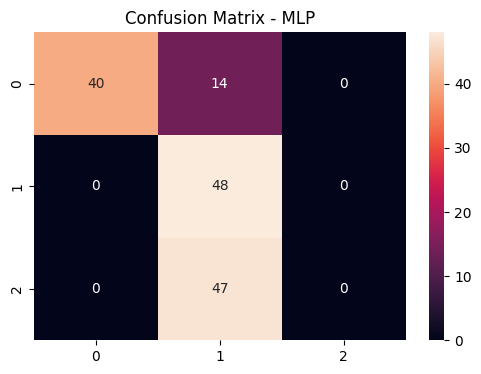

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


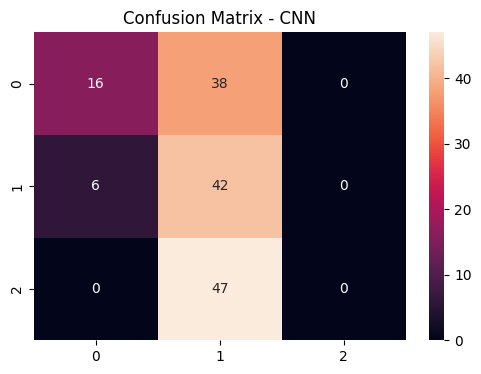

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


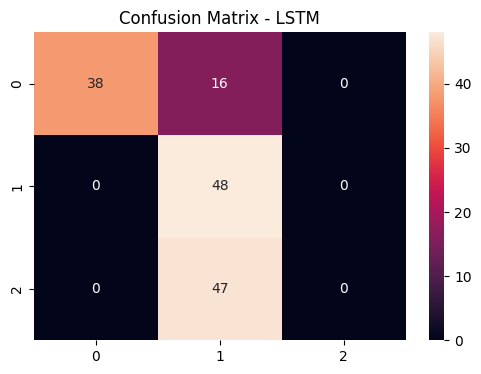

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


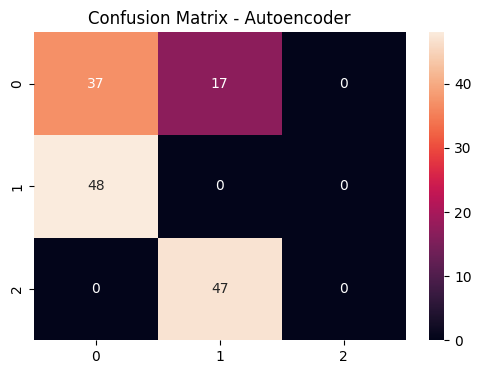

Deep Learning Results:
             accuracy        f1
MLP          0.590604  0.505421
CNN          0.389262  0.307227
LSTM         0.577181  0.493891
Autoencoder  0.248322  0.192941


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Reshape
from sklearn.metrics import confusion_matrix

def create_mlp():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_cnn():
    model = Sequential([
        Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
        Conv1D(32, 3, activation='relu'),
        Conv1D(64, 3, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm():
    model = Sequential([
        Reshape((1, X_train.shape[1]), input_shape=(X_train.shape[1],)),
        LSTM(64),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_autoencoder_classifier():
    input_dim = X_train.shape[1]
    encoder = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu')
    ])
    classifier = Sequential([
        Dense(32, activation='relu', input_shape=(16,)),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    autoencoder_classifier = Sequential([encoder, classifier])
    autoencoder_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return autoencoder_classifier

dl_models = {
    'MLP': create_mlp(),
    'CNN': create_cnn(),
    'LSTM': create_lstm(),
    'Autoencoder': create_autoencoder_classifier()
}

dl_results = {}
for name, model in dl_models.items():
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    y_pred_dl = (model.predict(X_test) > 0.5).astype(int).flatten()
    y_proba_dl = model.predict(X_test).flatten()

    dl_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred_dl),
        'f1': f1_score(y_test, y_pred_dl, average='weighted')
    }

    cm = confusion_matrix(y_test, y_pred_dl)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

dl_df = pd.DataFrame(dl_results).T
print("Deep Learning Results:")
print(dl_df)

In [19]:
!pip install shap
!pip install lime
!pip  install  lime.lime_tabular





ERROR: Could not find a version that satisfies the requirement lime.lime_tabular (from versions: none)
ERROR: No matching distribution found for lime.lime_tabular


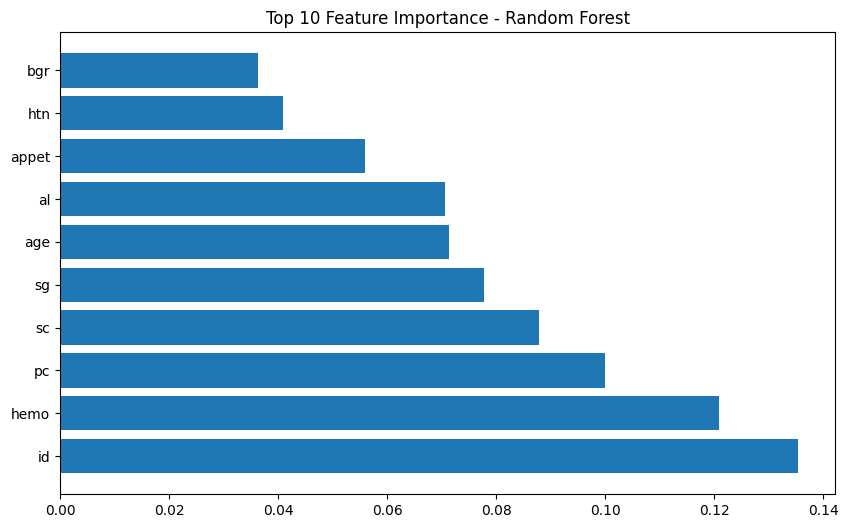

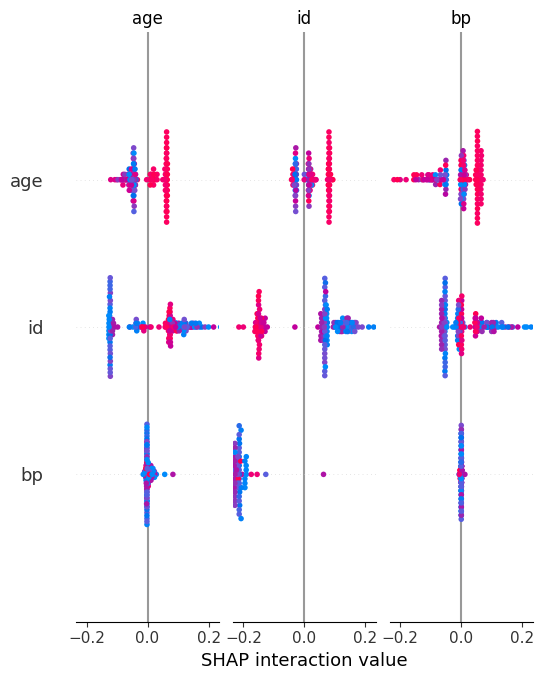

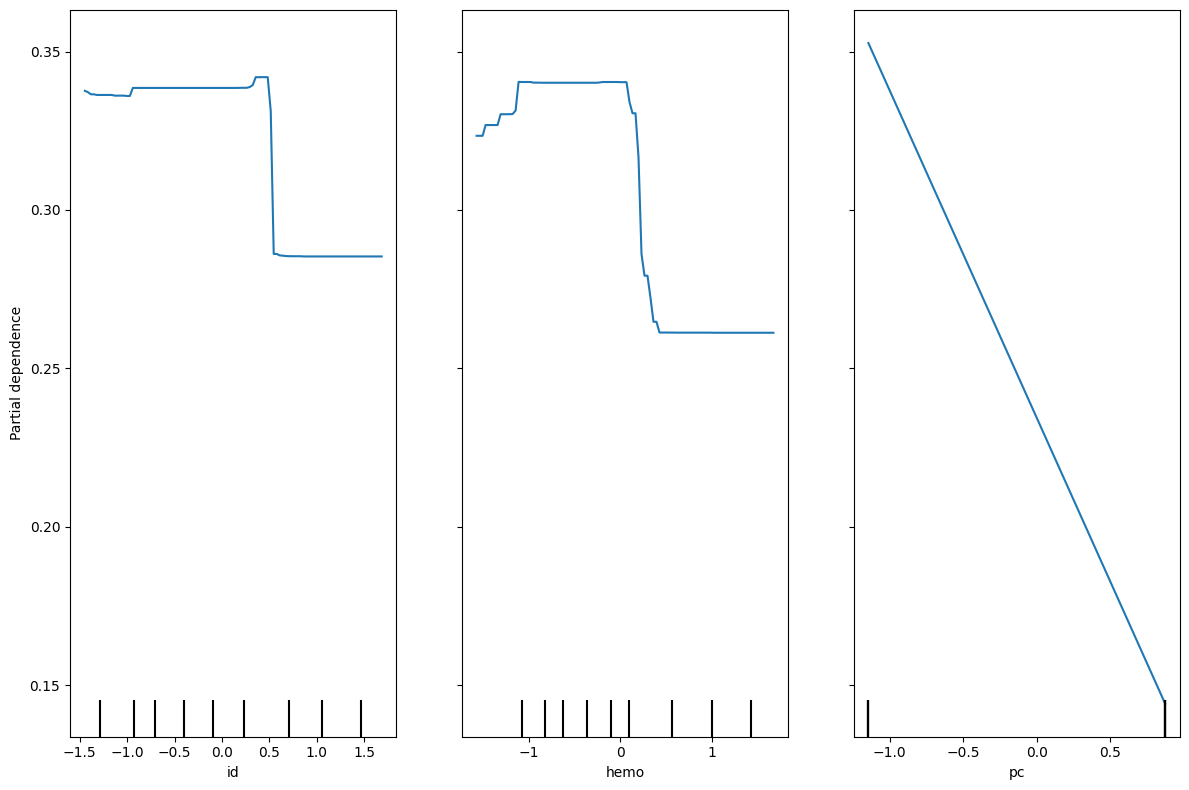

In [20]:
import shap
import lime.lime_tabular
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.title('Top 10 Feature Importance - Random Forest')
plt.show()

explainer_shap = shap.TreeExplainer(rf_model)
shap_values = explainer_shap.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=X.columns,
    class_names=['No Disease', 'Disease'], # Note: This might need adjustment for multi-class
    mode='classification'
)

idx = 0 # You can change this index to explain a different instance
exp = explainer_lime.explain_instance(X_test[idx], rf_model.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)

top_features = feature_importance['feature'][:3].tolist()
fig, ax = plt.subplots(figsize=(12, 8))
# Specify the target class for partial dependence plot (e.g., target=1)
PartialDependenceDisplay.from_estimator(
    rf_model, X_train, features=top_features,
    feature_names=X.columns, ax=ax, target=1
)
plt.tight_layout()
plt.show()

Comparative Analysis:
                accuracy  precision    recall        f1   roc_auc
ML logistic     0.986577   0.986854  0.986577  0.986520  1.000000
   dt           0.986577   0.986714  0.986577  0.986576  0.989786
   rf           1.000000   1.000000  1.000000  1.000000  1.000000
   svm          1.000000   1.000000  1.000000  1.000000  1.000000
   knn          0.979866   0.981074  0.979866  0.979889  1.000000
   xgb          0.993289   0.993411  0.993289  0.993283  0.999859
DL MLP          0.590604        NaN       NaN  0.505421       NaN
   CNN          0.389262        NaN       NaN  0.307227       NaN
   LSTM         0.577181        NaN       NaN  0.493891       NaN
   Autoencoder  0.248322        NaN       NaN  0.192941       NaN

Best ML Model: rf - F1 Score: 1.0000
Best DL Model: MLP - F1 Score: 0.5054


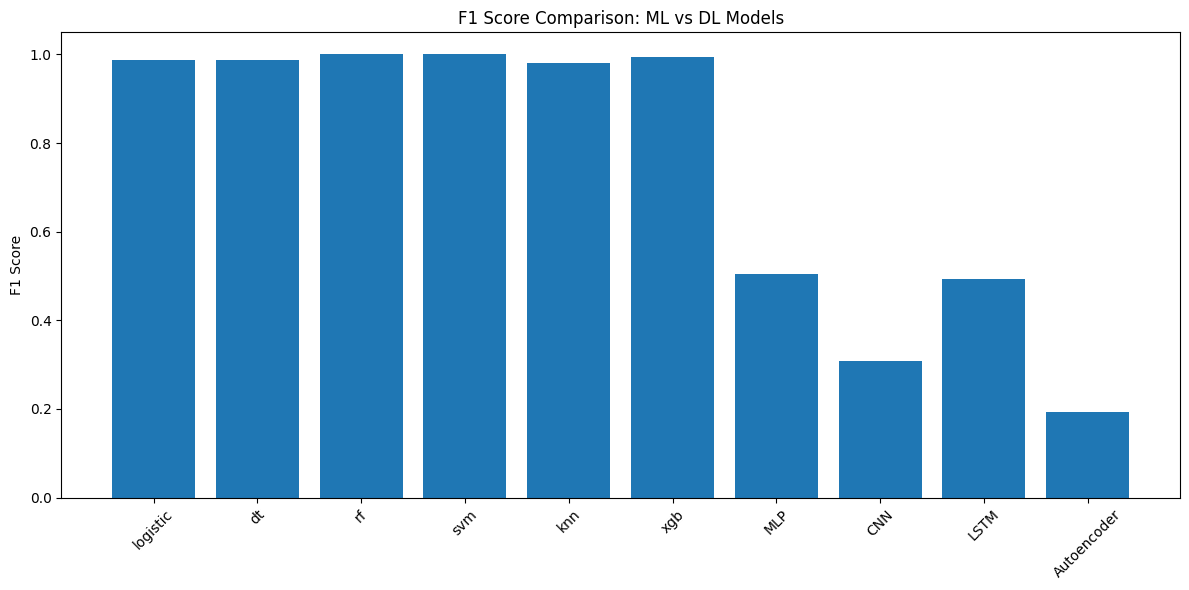


Recommendations:
1. Random Forest provides good balance of accuracy and interpretability
2. XGBoost often achieves highest performance but is less interpretable
3. For medical applications, prioritize interpretable models with SHAP/LIME explanations
4. Deep Learning models useful when dealing with large datasets and complex patterns


In [15]:
comparison_df = pd.concat([ml_df, dl_df], keys=['ML', 'DL'])
print("Comparative Analysis:")
print(comparison_df)

best_ml_model = ml_df.loc[ml_df['f1'].idxmax()]
best_dl_model = dl_df.loc[dl_df['f1'].idxmax()]

print(f"\nBest ML Model: {best_ml_model.name} - F1 Score: {best_ml_model['f1']:.4f}")
print(f"Best DL Model: {best_dl_model.name} - F1 Score: {best_dl_model['f1']:.4f}")

plt.figure(figsize=(12, 6))
models_combined = list(ml_results.keys()) + list(dl_results.keys())
f1_scores = [ml_results[m]['f1'] for m in ml_results] + [dl_results[m]['f1'] for m in dl_results]

plt.bar(models_combined, f1_scores)
plt.title('F1 Score Comparison: ML vs DL Models')
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.tight_layout()
plt.show()

print("\nRecommendations:")
print("1. Random Forest provides good balance of accuracy and interpretability")
print("2. XGBoost often achieves highest performance but is less interpretable")
print("3. For medical applications, prioritize interpretable models with SHAP/LIME explanations")
print("4. Deep Learning models useful when dealing with large datasets and complex patterns")